In [92]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import pandas as pd
import cv2 as cv
import glob
import time
import tensorflow as tf
from tensorflow.python.keras import layers
from keras.layers import Rescaling

%matplotlib inline

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LayerNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

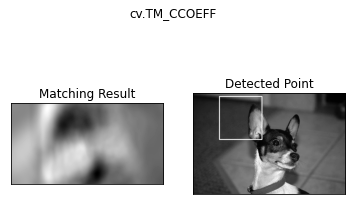

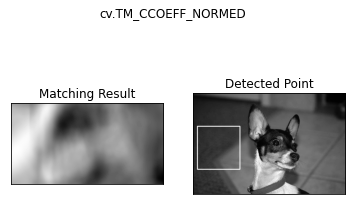

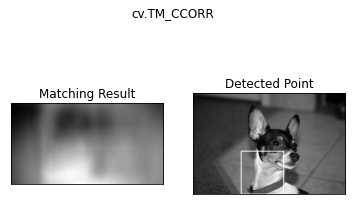

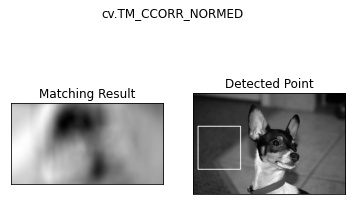

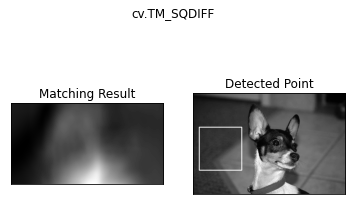

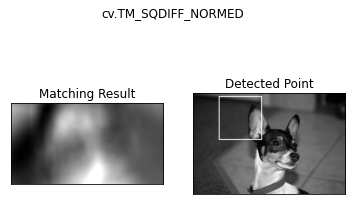

In [93]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
img = cv.imread("C:/Users/antoi/Dropbox/PC/Desktop/Images/n02087046-toy_terrier/n02087046_6443.jpg",0)
img2 = img.copy()
template = cv.imread("C:/Users/antoi/Dropbox/PC/Desktop/Projet 6/template.jpg",0)
w, h = template.shape[::-1]
# All the 6 methods for comparison in a list
methods = ['cv.TM_CCOEFF', 'cv.TM_CCOEFF_NORMED', 'cv.TM_CCORR',
            'cv.TM_CCORR_NORMED', 'cv.TM_SQDIFF', 'cv.TM_SQDIFF_NORMED']
for meth in methods:
    img = img2.copy()
    method = eval(meth)
    # Apply template Matching
    res = cv.matchTemplate(img,template,method)
    min_val, max_val, min_loc, max_loc = cv.minMaxLoc(res)
    # If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
    if method in [cv.TM_SQDIFF, cv.TM_SQDIFF_NORMED]:
        top_left = min_loc
    else:
        top_left = max_loc
    bottom_right = (top_left[0] + w, top_left[1] + h)
    cv.rectangle(img,top_left, bottom_right, 255, 2)
    plt.subplot(121),plt.imshow(res,cmap = 'gray')
    plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(img,cmap = 'gray')
    plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
    plt.suptitle(meth)
    plt.show()

In [94]:
dim=100

def Extract_Images_Test(Folder):
    temp=[]
    for filename in glob.glob('C:/Users/antoi/Dropbox/PC/Desktop/Images/' + Folder + '/*.jpg'):
        img=cv.imread(filename)
        temp.append([img,(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
    return(pd.DataFrame(temp,columns=['Image','Race']))


def Extract_Images(Folder):
    temp=[]
    for filename in glob.glob('C:/Users/antoi/Dropbox/PC/Desktop/Images/' + Folder + '/*.jpg'):
        img=cv.imread(filename)
        img=cv.resize(img,dsize=[100, 100])
        temp.append([img,(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
        temp.append([cv.flip(img,0),(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
        temp.append([cv.flip(img,1),(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
        temp.append([cv.flip(img,-1),(os.path.basename(Folder)).split('-')[1].replace('_',' ')])
    return(pd.DataFrame(temp,columns=['Image','Race']))

In [95]:
Folders=os.listdir('C:/Users/antoi/Dropbox/PC/Desktop/Images')
print(len(Folders))

120


# **Extending the models to the whole DataFrame**


In [96]:
num_classes=5

In [97]:
data=pd.DataFrame(columns=['Image','Race','RaceId'],dtype=np.float32)

In [98]:
i=0
for Folder in Folders[:num_classes]:
    tempdata=Extract_Images(Folder)
    data=pd.concat([data,pd.concat([tempdata,pd.DataFrame([i]*(tempdata.shape[0]),columns=['RaceId'])],axis=1)])
    i+=1

In [99]:
data.reset_index(inplace=True)

In [100]:
print(data.shape)

(3808, 4)


In [101]:
class_names=pd.unique(data['Race'])

In [102]:
data['Grayscale']=data['Image'].apply(lambda x : cv.cvtColor(x,cv.COLOR_BGR2GRAY))
data_original=data.copy()

In [103]:
data['Grayscale']=data['Grayscale'].apply(lambda x : cv.convertScaleAbs(cv.equalizeHist(x),alpha=1,beta=10))

In [104]:
for k in range(data['Image'].shape[0]):
    gray=data['Grayscale'][k]
    img=data['Image'][k]
    dst = cv.cornerHarris(gray,2,3,0.04)
    img[dst>0.005*dst.max()]=[255,0,0]
    if k%10000==0:
        print(k)

data=pd.concat([data,data_original],axis=0)
data_original=data.copy()

0


In [105]:
data.reset_index(inplace=True)

print(data.shape)

(7616, 6)


In [106]:
data['Grayscale']=data['Image'].apply(lambda x : cv.cvtColor(x,cv.COLOR_BGR2GRAY))

In [107]:
data['Grayscale']=data['Grayscale'].apply(lambda x : cv.convertScaleAbs(cv.equalizeHist(x),alpha=1,beta=10))


In [108]:
for k in range(data['Image'].shape[0]):
    gray=data['Grayscale'][k]
    img=data['Image'][k]
    sift = cv.xfeatures2d.SIFT_create()
    kp = sift.detect(img, None)
    img=cv.drawKeypoints(gray,kp,img)
    if k%10000==0:
        print(k)

0


In [109]:
data['Grayscale']=data['Image'].apply(lambda x : cv.cvtColor(x,cv.COLOR_BGR2GRAY))

In [110]:
data['Grayscale']=data['Grayscale'].apply(lambda x : cv.convertScaleAbs(cv.equalizeHist(x),alpha=1,beta=10))

In [111]:
data=pd.concat([data,data_original],axis=0)
data=data.drop(['level_0','index'],axis=1)
data.reset_index(inplace=True)
print(data.shape)

(15232, 5)


## Pre processing of the data

In [112]:
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, LayerNormalization
from tensorflow.keras import losses, optimizers
from tensorflow.keras import activations
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot


In [113]:
train_image,test_image,train_label, test_label = train_test_split(data.loc[:,['Image','Grayscale']],data.loc[:,['Race','RaceId']],stratify=data['RaceId'],test_size=0.1)

<AxesSubplot:xlabel='class', ylabel='prop'>

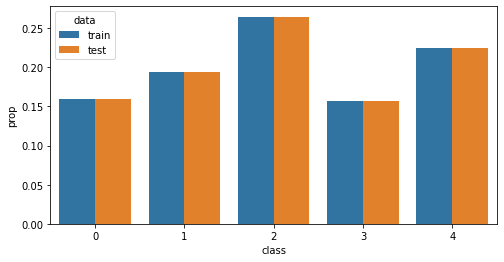

In [114]:
y_counts = pd.DataFrame({
    'data': np.array(['train'] * num_classes + ['test'] * num_classes),
    'class': np.tile(np.arange(num_classes), 2),
    'prop': np.hstack([np.bincount(train_label['RaceId']) / train_label.shape[0],
                         np.bincount(test_label['RaceId']) / test_label.shape[0]])
})

fig, ax = plt.subplots(figsize=(8, 4))
sns.barplot(x='class', y='prop', hue='data', data=y_counts, ax=ax)

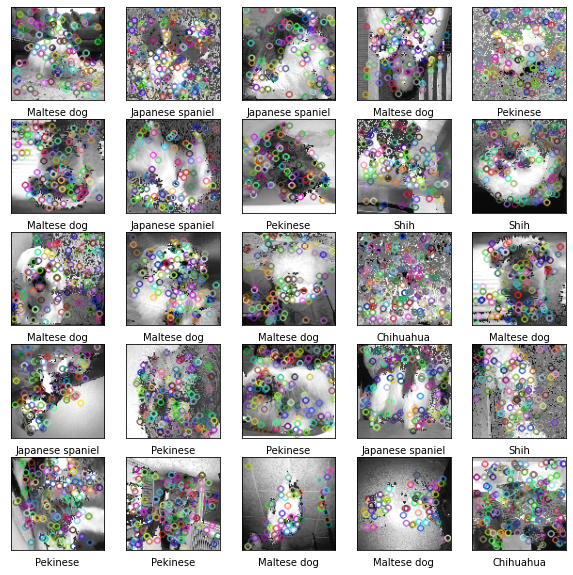

In [115]:
plt.figure(figsize=(10,10))
k=0
for i in train_image.index[:25]:
    plt.subplot(5,5,k+1)
    k+=1
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_image['Image'][i])
    plt.xlabel(train_label['Race'][i])
plt.show()

We normalize the data:

In [116]:
train_images = train_image['Image']
test_images = test_image['Image']

train_labels=train_label['RaceId']
test_labels=test_label['RaceId']


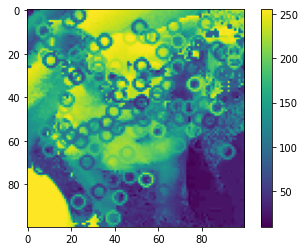

In [117]:
plt.figure()
plt.imshow(data['Grayscale'][0])
plt.colorbar()
plt.grid(False)
plt.show()

The scale of grey is now from 0 to 1.

In [118]:
# convert class vectors to binary class matrices
train_labels = to_categorical(train_labels, num_classes)
test_labels = to_categorical(test_labels, num_classes)
train_labels[:10]

array([[0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.]], dtype=float32)

In [119]:
train_labels.shape

(13708, 5)

In [120]:
test_labels.shape

(1524, 5)

###**Creation of a validation set**

We further split the train set into a train and validation set. The validation set will be 20% from the original train set, therefore the split will be train/validation of 0.8/0.2.

The actual training set will be divided into two groups:
* the training set
* the validation set

In [121]:

train_images, valid_images, train_labels, valid_labels = train_test_split(train_images, train_labels, test_size=0.2, random_state=2020)

In [122]:
train_id=train_image.index
valid_id=valid_images.index
test_id=test_image.index


In [123]:
partition = {'train' : [str(i) for i in train_id], 'validation' : [str(i) for i in valid_id]}

labels={}
for i in train_id:
    labels[str(i)]=train_labels
for i in valid_id:
    labels[str(i)]=valid_labels

In [124]:
train_images=np.asarray([i.astype(np.float32) for i in train_images])
train_labels=np.asarray([i.astype(np.float32) for i in train_labels])

valid_images=np.asarray([i.astype(np.float32) for i in valid_images])
valid_labels=np.asarray([i.astype(np.float32) for i in valid_labels])

test_images=np.asarray([i.astype(np.float32) for i in test_images])
test_labels=np.asarray([i.astype(np.float32) for i in test_labels])

In [125]:
valid_set= (valid_images,valid_labels)

In [126]:
batch_size=32
epochs=40
input_shape = train_images.shape[1:]

### **4th version of the CNN: Preventing overfitting and adding layers**

In [127]:
time0=time.time()
model_cnn4 = Sequential()
model_cnn4.add(Rescaling(1./255, input_shape=input_shape))
model_cnn4.add(Conv2D(16, kernel_size=10, activation='relu', input_shape=input_shape, name='conv2d_1'))
model_cnn4.add(MaxPooling2D(pool_size=3, name='max_pool_1'))
model_cnn4.add(Conv2D(32, kernel_size=8, activation='relu', name='conv2d_2'))
model_cnn4.add(MaxPooling2D(pool_size=2, name='max_pool_2'))
model_cnn4.add(Dropout(0.25, name='dropout_1'))
model_cnn4.add(Conv2D(32, kernel_size=6, activation='relu', name='conv2d_3'))
model_cnn4.add(MaxPooling2D(pool_size=2, name='max_pool_3'))
model_cnn4.add(Dropout(0.25, name='dropout_2'))
model_cnn4.add(Flatten(name='flatten'))
model_cnn4.add(Dense(50, activation='relu', name='dense'))
model_cnn4.add(Dense(num_classes, activation='softmax', name='output'))

model_cnn4.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

In [128]:
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

# Run the train
history_cnn4 = model_cnn4.fit(train_images, train_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=valid_set,
                            callbacks=[es])
score_cnn4 = model_cnn4.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_cnn4[0])
print('Test accuracy:', score_cnn4[1])
time1=time.time()-time0

Epoch 1/40
343/343 [==============================] - 4s 10ms/step - loss: 1.5911 - accuracy: 0.2601 - val_loss: 1.5638 - val_accuracy: 0.2877

*Remarks:*

We run the same models with different "batch_size" (10, 64, 128) and noticed that:
* for the firsts CNNs, a small batch_size led to better accuracy levels.
* However, for the last ones (which have been otpimized from the previous ones), changing the batch size didn't have a significant effect on the accuracy level.


### **5th version of the CNN: Fine-tuning and trials**

In [129]:

time0=time.time()
model_cnn5 = Sequential()
model_cnn5.add(Rescaling(1./255, input_shape=input_shape))
model_cnn5.add(LayerNormalization())
model_cnn5.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=input_shape))
model_cnn5.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model_cnn5.add(MaxPooling2D(pool_size=(3,3)))

model_cnn5.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_cnn5.add(MaxPooling2D(pool_size=(3,3)))

model_cnn5.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_cnn5.add(MaxPooling2D(pool_size=(3,3)))



model_cnn5.add(Flatten())
model_cnn5.add(Dense(num_classes*10, activation='relu'))
model_cnn5.add(Dropout(0.1))
model_cnn5.add(Dense(num_classes, activation='softmax'))

model_cnn5.compile(
   optimizer='adam',
   loss='categorical_crossentropy',
   metrics=['accuracy'],
)


model_cnn5.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 100, 100, 3)       0         
                                                                 
 layer_normalization (LayerN  (None, 100, 100, 3)      6         
 ormalization)                                                   
                                                                 
 conv2d (Conv2D)             (None, 98, 98, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 30, 30, 64)       

In [130]:
# Run the train
history_cnn5 = model_cnn5.fit(train_images, train_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=valid_set,
                            callbacks=[es])

Epoch 1/40
343/343 [==============================] - 7s 17ms/step - loss: 1.5714 - accuracy: 0.2793 - val_loss: 1.5396 - val_accuracy: 0.3155

In [131]:
score_cnn5 = model_cnn5.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_cnn5[0])
print('Test accuracy:', score_cnn5[1])
time1=time.time()-time0

Test loss: 0.1732652336359024
Test accuracy: 0.9763779640197754


# Re-training du VGG16

In [132]:
from keras.applications import VGG16
from tensorflow.python.keras import models

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
base_model.trainable = False ## Not trainable weights


flatten_layer = layers.Flatten()
dense_layer_1 = layers.Dense(num_classes*10, activation='relu')
dense_layer_2 = layers.Dense(num_classes*5, activation='relu')
dropout_layer = layers.Dropout(0.1)
prediction_layer = layers.Dense(num_classes, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
    dense_layer_1,
    dropout_layer,
    dense_layer_2,
    prediction_layer
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

history_model=model.fit(train_images, train_labels,
                            batch_size=batch_size,
                            epochs=epochs,
                            verbose=1,
                            validation_data=valid_set,
                            callbacks=[es])

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [ ]:
score_model = model.evaluate(test_images, test_labels, verbose=0)
print('Test loss:', score_model[0])
print('Test accuracy:', score_model[1])